<div style="background-color:#E50914; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h1 align="center" style="color:#ffffff;"><b>Netflix Movie Recommendation System 🎬</b></h1>
</div>

<div style="background-color:#000000; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <img src="https://media.tenor.com/NerN41mjgV0AAAAC/netflix-intro.gif" alt="Animated GIF">
</div>

<div style="background-color:#E50914; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#000000;"><b>IMPORT DEPENDENCIES</b></h2>
</div>

In [1]:
!pip3 install -q numpy pandas matplotlib plotly wordcloud scikit-learn

In [2]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.sparse import save_npz
import warnings
warnings.filterwarnings('ignore')

In [3]:
netflix_data = pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv")
netflix_data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


<div style="background-color:#E50914; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#000000;"><b>DATA PRE-PROCESSING AND EDA</b></h2>
</div>

In [4]:
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [5]:
netflix_data.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [6]:
netflix_data.fillna('', inplace=True)

In [7]:
netflix_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
show_id,8807,8807,s1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,8807,2,Movie,6131,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,8807,8807,Dick Johnson Is Dead,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,8807,4529,,2634,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cast,8807,7693,,825,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,8807,749,United States,2818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_added,8807,1768,"January 1, 2020",109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_year,8807.0,NaN,NaN,NaN,2014.180198,8.819312,1925.0,2013.0,2017.0,2019.0,2021.0
rating,8807,18,TV-MA,3207,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,8807,221,1 Season,1793,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
movie_counts = netflix_data['release_year'].value_counts().sort_index()
fig = go.Figure(data=go.Bar(x=movie_counts.index, y=movie_counts.values))
fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',  
    paper_bgcolor='rgb(17, 17, 17)',  
    font_color='white', 
    title='Number of Movies Released Each Year',  
    xaxis=dict(title='Year'),  
    yaxis=dict(title='Number of Movies')
)
fig.update_traces(marker_color='red')
fig.show()

In [9]:
movie_type_counts = netflix_data['type'].value_counts()

fig = go.Figure(data=go.Pie(labels=movie_type_counts.index, values=movie_type_counts.values))

fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',  
    paper_bgcolor='rgb(17, 17, 17)', 
    font_color='white',  
    title='Distribution of C. Types',
)
fig.update_traces(marker=dict(colors=['red']))
fig.show()

In [10]:
top_countries = netflix_data['country'].value_counts().head(10)

fig = px.treemap(names=top_countries.index, parents=["" for _ in top_countries.index], values=top_countries.values)

fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',  
    paper_bgcolor='rgb(17, 17, 17)', 
    font_color='white',  
    title='Top Countries with Highest Number of Movies',
)
fig.show()

In [11]:
country_movie_counts = netflix_data['country'].value_counts()

data = pd.DataFrame({'Country': country_movie_counts.index, 'Movie Count': country_movie_counts.values})

fig = px.choropleth(data_frame=data, locations='Country', locationmode='country names',
                    color='Movie Count', title='Number of Movies Released By Country',
                    color_continuous_scale='Reds', range_color=(0, data['Movie Count'].max()),
                    labels={'Movie Count': 'Number of Movies'})

fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',  
    paper_bgcolor='rgb(17, 17, 17)', 
    font_color='white' 
)
fig.show()

In [12]:
ratings       = list(netflix_data['rating'].value_counts().index)
rating_counts = list(netflix_data['rating'].value_counts().values)

fig = go.Figure(data=[go.Bar(
    x=ratings,
    y=rating_counts,
    marker_color='#E50914'
)])

fig.update_layout(
    title='Movie Ratings Distribution',
    xaxis_title='Rating',
    yaxis_title='Count',
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0.7)',
    font=dict(
        color='white'
    )
)

fig.show()

In [13]:
ratings       = list(netflix_data['duration'].value_counts().index)
rating_counts = list(netflix_data['duration'].value_counts().values)

fig = go.Figure(data=[go.Bar(
    x=ratings,
    y=rating_counts,
    marker_color='#E50914'
)])

fig.update_layout(
    title='Movie Durations Distribution',
    xaxis_title='Rating',
    yaxis_title='Count',
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0.7)',
    font=dict(
        color='white'
    )
)

fig.show()

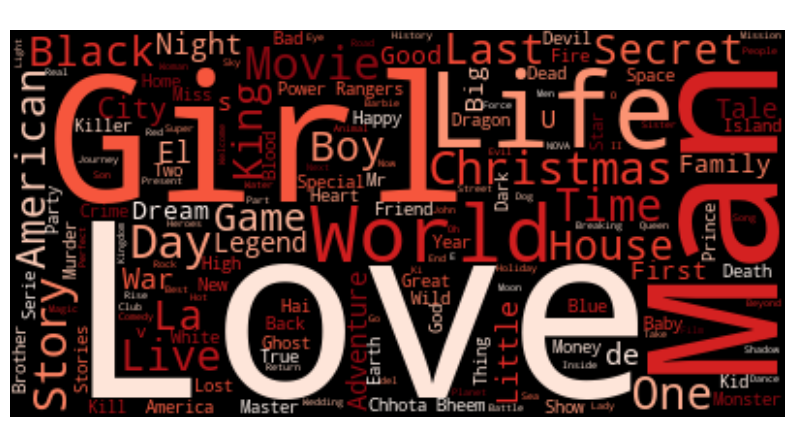

In [14]:
titles = netflix_data['title'].values

text = ' '.join(titles)

wordcloud = WordCloud(background_color='black', colormap='Reds').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Netflix Titles', color='white')
plt.show()

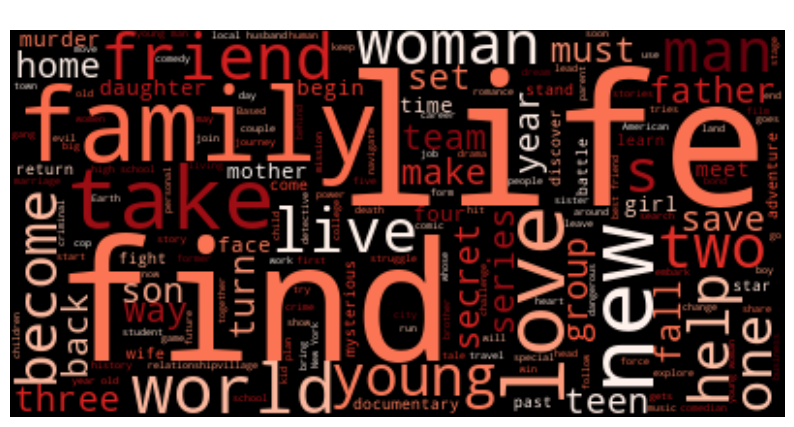

In [15]:
titles = netflix_data['description'].values

text = ' '.join(titles)

wordcloud = WordCloud(background_color='black', colormap='Reds').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Netflix Descriptions', color='white')
plt.show()

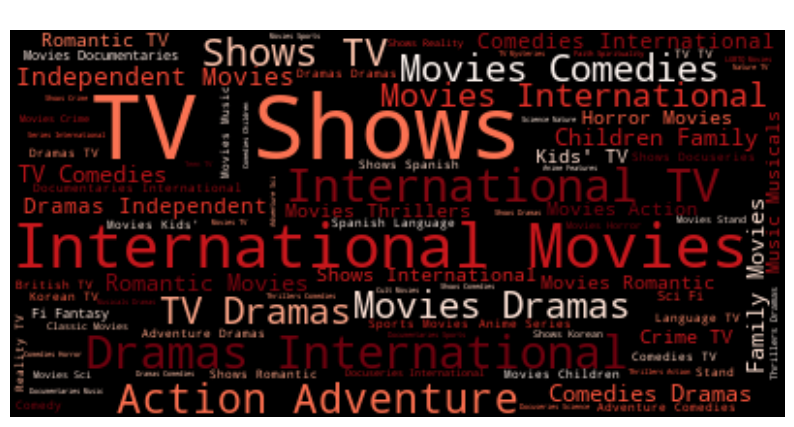

In [16]:
titles = netflix_data['listed_in'].values

text = ' '.join(titles)

wordcloud = WordCloud(background_color='black', colormap='Reds').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Netflix Descriptions', color='white')
plt.show()

In [17]:
netflix_data

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,,,,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,,,,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


<div style="background-color:#E50914; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#000000;"><b>FEATURE ENGINEERING</b></h2>
</div>

In [18]:
new_data = netflix_data[['title', 'type', 'director', 'cast', 'rating', 'listed_in', 'description']]
new_data.set_index('title', inplace=True)

In [19]:
new_data.head()

,type,director,cast,rating,listed_in,description
title,,,,,,
Dick Johnson Is Dead,Movie,Kirsten Johnson,,PG-13,Documentaries,"As her father nears the end of his life, filmm..."
Blood & Water,TV Show,,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",TV-MA,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
Ganglands,TV Show,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",TV-MA,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
Jailbirds New Orleans,TV Show,,,TV-MA,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
Kota Factory,TV Show,,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",TV-MA,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [20]:
class TextCleaner:
    def separate_text(self, texts):
        unique_texts = set()
        for text in texts.split(','):
            unique_texts.add(text.strip().lower())
        return ' '.join(unique_texts)

    def remove_space(self, texts):
        return texts.replace(' ', '').lower()

    def remove_punc(self, texts):
        texts = texts.lower()
        texts = texts.translate(str.maketrans('', '', string.punctuation))
        return ' '.join(texts.split())

    def clean_text(self, texts):
        texts = self.separate_text(texts)
        texts = self.remove_space(texts)
        texts = self.remove_punc(texts)
        return texts

In [21]:
cleaner = TextCleaner()

In [22]:
new_data['type']        = new_data['type'].apply(cleaner.remove_space)
new_data['director']    = new_data['director'].apply(cleaner.separate_text)
new_data['cast']        = new_data['cast'].apply(cleaner.separate_text)
new_data['rating']      = new_data['rating'].apply(cleaner.remove_space)
new_data['listed_in']   = new_data['listed_in'].apply(cleaner.separate_text)
new_data['description'] = new_data['description'].apply(cleaner.remove_punc)

In [23]:
new_data.head()

,type,director,cast,rating,listed_in,description
title,,,,,,
Dick Johnson Is Dead,movie,kirsten johnson,,pg-13,documentaries,as her father nears the end of his life filmma...
Blood & Water,tvshow,,cindy mahlangu xolile tshabalala sandi schultz...,tv-ma,tv dramas international tv shows tv mysteries,after crossing paths at a party a cape town te...
Ganglands,tvshow,julien leclercq,noureddine farihi samuel jouy bakary diombera ...,tv-ma,international tv shows crime tv shows tv actio...,to protect his family from a powerful drug lor...
Jailbirds New Orleans,tvshow,,,tv-ma,reality tv docuseries,feuds flirtations and toilet talk go down amon...
Kota Factory,tvshow,,urvi singh ranjan raj mayur more alam khan rev...,tv-ma,tv comedies romantic tv shows international tv...,in a city of coaching centers known to train i...


In [24]:
new_data['BoW'] = new_data.apply(lambda row: ' '.join(row.dropna().values), axis=1)
new_data.drop(new_data.columns[:-1], axis=1, inplace=True)

In [25]:
new_data.head()

,BoW
title,
Dick Johnson Is Dead,movie kirsten johnson pg-13 documentaries as ...
Blood & Water,tvshow cindy mahlangu xolile tshabalala sandi...
Ganglands,tvshow julien leclercq noureddine farihi samue...
Jailbirds New Orleans,tvshow tv-ma reality tv docuseries feuds fli...
Kota Factory,tvshow urvi singh ranjan raj mayur more alam ...


In [26]:
tfid = TfidfVectorizer()
tfid_matrix = tfid.fit_transform(new_data['BoW'])

In [27]:
cosine_sim = cosine_similarity(tfid_matrix, tfid_matrix)
cosine_sim

array([[1.        , 0.00504833, 0.02011193, ..., 0.01065369, 0.02109898,
        0.03048859],
       [0.00504833, 1.        , 0.01714561, ..., 0.00103121, 0.        ,
        0.00481712],
       [0.02011193, 0.01714561, 1.        , ..., 0.00560911, 0.01042642,
        0.0333502 ],
       ...,
       [0.01065369, 0.00103121, 0.00560911, ..., 1.        , 0.05649084,
        0.00600011],
       [0.02109898, 0.        , 0.01042642, ..., 0.05649084, 1.        ,
        0.01046521],
       [0.03048859, 0.00481712, 0.0333502 , ..., 0.00600011, 0.01046521,
        1.        ]])

In [28]:
cosine_sim

array([[1.        , 0.00504833, 0.02011193, ..., 0.01065369, 0.02109898,
        0.03048859],
       [0.00504833, 1.        , 0.01714561, ..., 0.00103121, 0.        ,
        0.00481712],
       [0.02011193, 0.01714561, 1.        , ..., 0.00560911, 0.01042642,
        0.0333502 ],
       ...,
       [0.01065369, 0.00103121, 0.00560911, ..., 1.        , 0.05649084,
        0.00600011],
       [0.02109898, 0.        , 0.01042642, ..., 0.05649084, 1.        ,
        0.01046521],
       [0.03048859, 0.00481712, 0.0333502 , ..., 0.00600011, 0.01046521,
        1.        ]])

In [29]:
np.save('tfidf_matrix.npy', tfid_matrix)
np.save('cosine_sim_matrix.npy', cosine_sim)

In [30]:
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfid, f)

In [31]:
final_data = netflix_data[['title', 'type']]

In [32]:
final_data.head()

,title,type
0,Dick Johnson Is Dead,Movie
1,Blood & Water,TV Show
2,Ganglands,TV Show
3,Jailbirds New Orleans,TV Show
4,Kota Factory,TV Show


In [33]:
final_data.to_csv('movie_data.csv',index=False)

<div style="background-color:#E50914; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#000000;"><b>_ Movie Recommendation System 🎬 (FLIX-HUB) _</b></h2>
</div>

In [34]:
import re
class FlixHub:
    def __init__(self, df, cosine_sim):
        self.df = df
        self.cosine_sim = cosine_sim
    
    def recommendation(self, title, total_result=5, threshold=0.5):
        idx = self.find_id(title)
        self.df['similarity'] = self.cosine_sim[idx]
        sort_df = self.df.sort_values(by='similarity', ascending=False)[1:total_result+1]
        
        movies = sort_df['title'][sort_df['type'] == 'Movie']
        tv_shows = sort_df['title'][sort_df['type'] == 'TV Show']
        
        similar_movies = []
        similar_tv_shows = []
        
        for i, movie in enumerate(movies):
            similar_movies.append('{}. {}'.format(i+1, movie))
        
        for i, tv_show in enumerate(tv_shows):
            similar_tv_shows.append('{}. {}'.format(i+1, tv_show))
        
        return similar_movies, similar_tv_shows

    def find_id(self, name):
        for index, string in enumerate(self.df['title']):
            if re.search(name, string):
                return index
        return -1

In [35]:
flix_hub = FlixHub(final_data, cosine_sim)
movies, tv_shows = flix_hub.recommendation('Blood & Water', total_result=10, threshold=0.5)

print('Similar Movie(s) list:')
for movie in movies:
    print(movie)

print('\nSimilar TV_show(s) list:')
for tv_show in tv_shows:
    print(tv_show)

Similar Movie(s) list:
1. Shirkers
2. Frank and Cindy
3. Adam: His Song Continues
4. Walk Away from Love
5. Mom

Similar TV_show(s) list:
1. Diamond City
2. Kings of Jo'Burg
3. Lion Pride
4. Forget Me Not
5. Horrid Henry


In [36]:
flix_hub = FlixHub(final_data, cosine_sim)
movies, tv_shows = flix_hub.recommendation('Chappie', total_result=10, threshold=0.5)

print('Similar Movie(s) list:')
for movie in movies:
    print(movie)

print('\nSimilar TV_show(s) list:')
for tv_show in tv_shows:
    print(tv_show)

Similar Movie(s) list:
1. District 9
2. Real Steel
3. The Last Days of American Crime
4. 2036 Origin Unknown
5. Singularity
6. AlphaGo
7. Hardcore Henry
8. A Monster Calls
9. Equals

Similar TV_show(s) list:
1. Taken
